In [2]:
# survey of identified altProts

In [54]:
import pickle
import numpy as np
from collections import Counter
from matplotlib import pyplot as plt
from gtfparse import read_gtf
from altProts_in_communities.utils import *

In [55]:
bioplex_psms = pickle.load(open('OP16_bioplex_all_psms.pkl', 'rb'))

In [56]:
detection_summary = pickle.load(open('detection_summary.pkl', 'rb'))
detected_alts = set([x[0] for x in detection_summary if x[-1]])
len(detected_alts)

278

In [57]:
pickle.dump(detected_alts, open('detected_alts.pkl', 'wb'))

In [58]:
OP_unfiltered_edges = set()
altProts = set()
for bait, exps in bioplex_psms.items():
    for exp_id, exp in exps['exps'].items():
        for prey, psms in exp['psms'].items():
            OP_unfiltered_edges.add(frozenset((bait, prey)))
            if is_alt(prey):
                altProts.add(prey)
print('OP_unfiltered_edges:', len(OP_unfiltered_edges))
print('altProts: ', len(altProts))

OP_unfiltered_edges: 1072268
altProts:  426


alt med len: 	 77.0
 alt mean len: 	 108.66187050359713
 ref med len: 	 472.0
 ref mean len: 	 624.7265060240964



/home/sleblanc/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


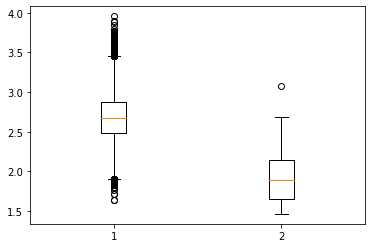

/home/sleblanc/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


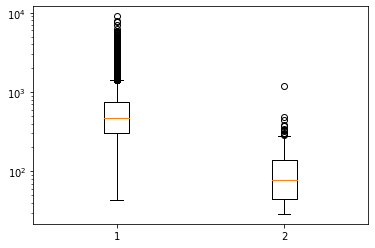

In [59]:
# distribution of protein lengths
all_refs = set([x for y in list(OP_unfiltered_edges) for x in y if not is_alt(x)])
alt_prot_lens = [protgene_len_dict[alt_acc] for alt_acc in list(detected_alts)]
ref_prot_lens = [protgene_len_dict[x] for x in list(all_refs) if x in protgene_len_dict]
missing_gene_protlen = [x for x in list(all_refs) if x not in protgene_len_dict]

print(
    'alt med len: \t {}\n'.format(np.median(alt_prot_lens)),
    'alt mean len: \t {}\n'.format(np.mean(alt_prot_lens)),
    'ref med len: \t {}\n'.format(np.median(ref_prot_lens)),
    'ref mean len: \t {}\n'.format(np.mean(ref_prot_lens)),
     )

plt.boxplot((np.log10(np.array(ref_prot_lens)), np.log10(np.array(alt_prot_lens))))
plt.savefig('bioplex_figures/prot_len_boxplot.svg')
plt.show()

plt.boxplot((np.array(ref_prot_lens), np.array(alt_prot_lens)))
plt.yscale('log')
plt.savefig('bioplex_figures/prot_len_boxplot_log.svg')

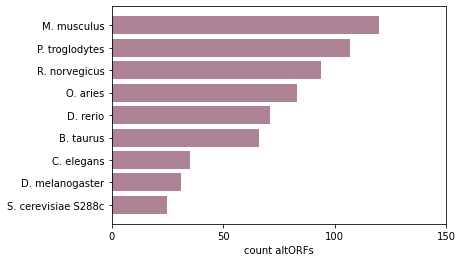

In [60]:
# conservation
ortho_species  = []
processed_alts = set()
with open('human-openprot-r1_6-refprots+altprots+isoforms-+uniprot2019_03_01.tsv', 'r') as f:
    reader = csv.reader(f, delimiter='\t')
    for n,row in enumerate(reader):
        if n==0:continue
        if n==1:
            tsv_row = row
            continue
        line=dict(zip(tsv_row, row))
        if not is_alt(line['protein accession numbers']): continue
        if line['protein accession numbers'] in detected_alts and line['protein accession numbers'] not in processed_alts:
            processed_alts.add(line['protein accession numbers'])
            if int(line['Orthology Across 10 Species # : Species Names'].split(':')[0])>0:
                species = line['Orthology Across 10 Species # : Species Names'].split(':')[1].split(',')
                for s in species:
                    ortho_species.append(s)

lab, cnt = zip(*sorted(Counter(ortho_species).items(), key=lambda x: x[1]))
species = ['{}. {}'.format(sp.split()[0][0], ' '.join(sp.split()[1:])) for sp in lab]

plt.barh(species, cnt, color='#AE8395')
plt.xlabel('count altORFs')
plt.xticks([0, 50, 100, 150])
plt.savefig('bioplex_figures/ortho_bars.svg')
plt.show()

In [61]:
# load trxp gene and biotype dictionaries
trxp_biotypes = pickle.load(open('trxp_biotypes.pkl', 'rb'))
refseq_trxp_gene, refseq_pseudo_set = pickle.load(open('refseq_trxp_gene.pkl', 'rb'))
gene_biotypes = pickle.load(open('gene_biotypes.pkl', 'rb'))
interpro = pickle.load(open('interpro.pkl', 'rb'))
coding_gene_alt_locs = pickle.load(open('coding_gene_alt_locs.pkl', 'rb'))
reports_all_alts = pickle.load(open('reports_all_alts.pkl', 'rb'))
prot_trxp_dict = pickle.load(open('prot_trxp_dict.pkl', 'rb'))
trxp_genes = pickle.load(open('trxp_genes.pkl', 'rb'))
alt_trxp_locs = pickle.load(open('alt_trxp_locs.pkl', 'rb')) # start-stop coord
trxp_len_dict = pickle.load(open('trxp_len_dict.pkl', 'rb'))

In [62]:
trxp_alt_loc = dict()
with open('human-openprot-r1_6-refprots+altprots+isoforms-+uniprot2019_03_01.tsv', 'r') as f:
    reader = csv.reader(f, delimiter='\t')
    for n, row in enumerate(reader):
        if n==0: continue
        if n==1:
            cols = row
            continue
        line = dict(zip(cols, row))
        if line['protein type'] == 'AltProt':
            trxp_acc = line['transcript accession'].split('.')[0]
            trxp_alt_loc[(line['protein accession numbers'], trxp_acc)] = line['localization']

In [63]:
alt_gene_biotypes = []
for alt in list(detected_alts):
    gene = prot_gene_dict[alt]
    gene_biotype, short_biotype  = 'NA', 'NA'
    if gene in gene_biotypes:
        gene_biotype = gene_biotypes[gene]
    if 'pseudogene' in gene_biotype:
        short_biotype = 'pseudogene'
    elif gene_biotype == 'protein_coding':
        short_biotype = 'protein_coding'
    else:
        short_biotype = 'non_coding'
    alt_sig_id, alt_sig_desc, alt_inter_ids = ['NA']*3
    if alt in interpro:
        alt_sig_id = '|'.join(list(set([str(x) for x in interpro[alt]['sig_accs']])))
        alt_sig_desc = '|'.join(list(set([str(x) for x in interpro[alt]['sig_desc']])))
        alt_inter_ids = '|'.join(list(set([str(x) for x in interpro[alt]['ipr_ids']])))
    prot_len = protgene_len_dict[alt]
    gene_type = 'protein coding'
    if alt in coding_gene_alt_locs:
        if 'CDS' in coding_gene_alt_locs[alt]:
            gene_type = 'dual coding'
        elif 'UTR' in coding_gene_alt_locs[alt]:
            gene_type = 'bicistronic'
        else:
            gene_type = 'protein coding'
    else:
        gene_type = 'protein coding'
        
    peptides = list(set([x[0] for x in reports_all_alts[alt.replace('IP_243680', 'IP_2287811')]['psms']]))
    
    alt_gene_biotype = (alt, gene, gene_biotype, short_biotype, gene_type, prot_len, len(peptides), '|'.join(peptides), alt_sig_desc, alt_inter_ids, alt_sig_id)
    if any(x=='NA' for x in [gene_biotype, short_biotype]):
        print("'{}':'ncRNA'".format(alt_gene_biotype[1]))
    alt_gene_biotypes.append(alt_gene_biotype)

'LOC107986577':'ncRNA'
'LOC729291':'ncRNA'
'LOC105371269':'ncRNA'
'LOC105378533':'ncRNA'
'LOC105376850':'ncRNA'
'LOC643387':'ncRNA'
'LOC107985687':'ncRNA'
'LOC101927245':'ncRNA'
'LOC105371768':'ncRNA'
'LOC105372310':'ncRNA'
'LOC105372558':'ncRNA'
'LOC105379404':'ncRNA'
'LOC105378773':'ncRNA'
'LOC105376156':'ncRNA'


In [64]:
alt_gene_biotypes_cols = (
    'altProt accession', 
    'gene', 
    'gene biotype', 
    'gene biotype summarized', 
    'gene coding type', 
    'length (aa)', 
    'n unique peptides', 
    'peptides', 
    'interpro signature description', 
    'interpro signature accession', 
    'interpro signature ids'
)
alt_gene_biotypes_dict = {}
for alt_gene_biotype in alt_gene_biotypes:
    alt_gene_biotype_dict = dict(zip(alt_gene_biotypes_cols, alt_gene_biotype))
    alt_gene_biotypes_dict[alt_gene_biotype_dict['altProt accession']] = alt_gene_biotype_dict

In [65]:
selected_trxps = {}
for alt_acc in list(detected_alts):
    if alt_acc == 'IP_2287811':
        alt_acc = 'IP_243680'
    trxps = []
    for t_acc in prot_trxp_dict[alt_acc]:
        if t_acc in trxp_biotypes and trxp_biotypes[t_acc]=='protein_coding':
            t_biotype = 1
        elif any(x in t_acc for x in ['NM_', 'XM_']):
            t_biotype = 1
        else:
            t_biotype = 0
        trxps.append(
            {
                't_acc':t_acc,
                't_gene':trxp_genes[t_acc],
                't_biotype':t_biotype,
                't_len':trxp_len_dict[t_acc],
            }
        )
    trxps = sorted(trxps, key=lambda x: [-x['t_biotype'], -x['t_len']])
    selected_trxps[alt_acc] = trxps[0]['t_acc']

In [66]:
trxp_mult_alts = []
for gene, alt_grp in itt.groupby(sorted([x for x in ev1 if x['gene biotype']!='protein_coding'], key=lambda x: x['gene']), key=lambda x: x['gene']):
    gene_alts = list(alt_grp)
    alt_acc_set = set(x['altProt accession'] for x in gene_alts)
    if len(alt_acc_set)>1:
        for gene_alt in gene_alts:
            alt_trxp = (gene_alt['altProt accession'], gene_alt['transcript accession'])
            trxp_mult_alts.append((gene_alt['transcript accession'], gene_alt['altProt accession'], alt_trxp_locs[alt_trxp]['start'], alt_trxp_locs[alt_trxp]['end']))

In [67]:
def ranges_overlap(range1, range2):
    s1, e1 = range1
    s2, e2 = range2
    total_len = max((e1, e2)) - min((s1, s2))
    total_seq = np.zeros(total_len)
    total_seq[s1:e1] += 1
    total_seq[s2:e2] += 1
    if max(total_seq)>1:
        return True
    return False

In [68]:
trxp_mult_alts_biotypes = {}
for trxp_acc, trxp_alt_grp in itt.groupby(sorted(trxp_mult_alts), key=lambda x: x[0]):
    trxp_alt = [x[1:] for x in trxp_alt_grp]
    if not len(trxp_alt)>1: continue
    range1 = trxp_alt[0][1:]
    range2 = trxp_alt[1][1:]
    if ranges_overlap(range1, range2):
        trxp_mult_alts_biotypes[trxp_acc] = 'dual coding'
    else:
        trxp_mult_alts_biotypes[trxp_acc] = 'bicistronic'

In [69]:
alt_trxps = {}
for tt_acc in list(detected_alts):
    if tt_acc == 'IP_2287811':
        tt_acc = 'IP_243680'
    for t_acc in prot_trxp_dict[tt_acc]:
        gene = trxp_genes[t_acc]
        g_biotype = gene_biotypes[gene] if gene in gene_biotypes else 'NA'
        if t_acc in trxp_biotypes:
            t_biotype = trxp_biotypes[t_acc]
        elif any(x in t_acc for x in ['NM_', 'XM_']):
            t_biotype = 'protein_coding'
        else:
            t_biotype = 'non_coding'
        loc = trxp_alt_loc[(tt_acc, t_acc)] if (tt_acc, t_acc) in trxp_alt_loc else 'NA'
        
        trxp_code_type = 'single CDS'
        if 'CDS' in loc:
            trxp_code_type = 'dual coding'
        elif 'UTR' in loc:
            trxp_code_type = 'bicistronic'
        if t_acc in trxp_mult_alts_biotypes:
            trxp_code_type = trxp_mult_alts_biotypes[t_acc]
        alt_trxps[(t_acc, tt_acc)] = {
            't_biotype':t_biotype, 
            'loc':loc, 
            'gene':gene, 
            'g_biotype':g_biotype,
            'transcript coding type':trxp_code_type,
            'selected_trxp':tt_acc==selected_trxps[tt_acc]
        }

In [70]:
ev1 = []
for t_acc, alt_acc in alt_trxps:
    ev1.append(
        {
            'altProt accession':alt_acc,
            'length (aa)':protgene_len_dict[alt_acc],
            'gene':alt_trxps[(t_acc, alt_acc)]['gene'],
            'gene biotype':alt_trxps[(t_acc, alt_acc)]['g_biotype'],
            'transcript accession':t_acc,
            'transcript biotype':alt_trxps[(t_acc, alt_acc)]['t_biotype'],
            'proposed transcript biotype':'protein_coding',
            'location relative to ref':alt_trxps[(t_acc, alt_acc)]['loc'],
            'multi-coding type':alt_trxps[(t_acc, alt_acc)]['transcript coding type'], 
            'interpro description':alt_gene_biotypes_dict[alt_acc]['interpro signature description'], 
            'interpro accession':alt_gene_biotypes_dict[alt_acc]['interpro signature accession'], 
            'interpro ids':alt_gene_biotypes_dict[alt_acc]['interpro signature ids']
        }
    )

pickle.dump(ev1, open('ev1.pkl', 'wb'))

In [71]:
ev1 = pickle.load(open('ev1.pkl', 'rb'))

In [72]:
len(set(x['altProt accession'] for x in ev1))

278

In [73]:
len(set(x['transcript accession'] for x in ev1))

971

In [74]:
len(set([x['altProt accession'] for x in ev1 if x['interpro ids']!='NA']))

147

In [75]:
Counter([x['multi-coding type'] for x in ev1])

Counter({'bicistronic': 298, 'dual coding': 384, 'single CDS': 304})

In [76]:
len(set([x['gene'] for x in ev1 if x['multi-coding type'] == 'dual coding']))

56

In [77]:
len(set([x['gene'] for x in ev1 if x['multi-coding type'] == 'bicistronic']))

70

In [78]:
len(set([x['gene'] for x in ev1 if x['multi-coding type'] == 'dual coding' and 'pseudogene' in x['gene biotype']]))

0

In [79]:
len(set([x['gene'] for x in ev1 if x['multi-coding type'] == 'bicistronic' and 'pseudogene' in x['gene biotype']]))

3

In [80]:
Counter([x['gene biotype'] for x in ev1])

Counter({'antisense': 51,
         'protein_coding': 739,
         'NA': 24,
         'processed_transcript': 3,
         'processed_pseudogene': 95,
         'transcribed_unprocessed_pseudogene': 26,
         'lincRNA': 15,
         'TEC': 1,
         'ncRNA': 10,
         'transcribed_processed_pseudogene': 14,
         'unprocessed_pseudogene': 7,
         'pseudogene': 1})

In [81]:
cols = (
    'altProt accession',
    'length (aa)',
    'gene',
    'gene biotype',    
    'transcript accession',
    'transcript biotype',
    'location relative to ref',
    'proposed transcript biotype',
    'multi-coding type',
    'interpro description', 
    'interpro accession', 
    'interpro ids'
)

with open('bioplex_tables/Table_EV1.tsv', 'w') as f:
    writer = csv.writer(f, delimiter='\t')
    writer.writerow(cols)
    for row in ev1:
        writer.writerow([row[col] for col in cols])

In [82]:
# excel
from openpyxl import Workbook
from openpyxl.utils import get_column_letter
from openpyxl.styles import PatternFill, Border, Side, Alignment, Protection, Font

select_trxp_ft = Font(bold=True)

wb = Workbook()
dest_filename = 'bioplex_tables/Table_EV1.xlsx'
ws1 = wb.active
ws1.title = "EV1"
ws1.append(cols)
for n, row in enumerate(ev1):
    row_idx = n+2
    ws1.append([row[col] for col in cols])
    if n<1:
        last_merge_idx = row_idx
        prev_alt_acc = row['altProt accession']
        continue
    if row['altProt accession'] != prev_alt_acc:
        for merge_col in ['A', 'B', 'J', 'K', 'L']:
            ws1.merge_cells('{merge_col}{range_start}:{merge_col}{range_end}'.format(merge_col=merge_col, range_start=last_merge_idx, range_end=row_idx-1))
        last_merge_idx = row_idx
    if selected_trxps[row['altProt accession']] == row['transcript accession']:
        ws1['E{}'.format(row_idx)].font = select_trxp_ft
    prev_alt_acc = row['altProt accession']
    
wb.save(filename = dest_filename)

In [51]:
cnt_prot_coding = len(set([x['altProt accession'] for x in ev1 if x['gene biotype'] == 'protein_coding']))
cnt_pseudo = len(set([x['altProt accession'] for x in ev1 if 'pseudogene' in x['gene biotype']]))

alt_biotype_cnts = {
    'protein coding':cnt_prot_coding,
    'pseudogene':cnt_pseudo, 
    'non coding':len(detected_alts)-cnt_prot_coding-cnt_pseudo, 
}

print(alt_biotype_cnts, sum(alt_biotype_cnts.values()))

{'protein coding': 118, 'pseudogene': 117, 'non coding': 43} 278


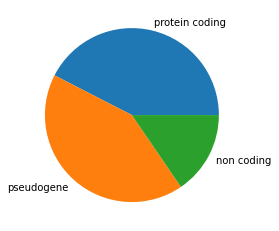

In [52]:
labels, counts = zip(*alt_biotype_cnts.items())
plt.pie(counts, labels=labels)
plt.savefig('bioplex_figures/biotype_pie.svg')
plt.show()

In [54]:
location_cnts = dict(Counter(
    [x['location relative to ref'] for x in ev1 if x['transcript accession']==selected_trxps[x['altProt accession']] and x['gene biotype']=='protein_coding']
))
print(location_cnts, sum(location_cnts.values()))

{'CDS': 50, "5'UTR": 16, "3'UTR": 37, '-': 15} 118


In [55]:
sum(location_cnts[loc] for loc in ['CDS', "3'UTR", "5'UTR"])

103

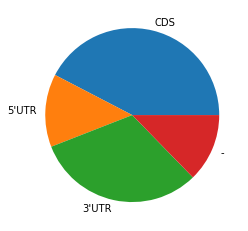

In [56]:
labels, counts = zip(*location_cnts.items())
plt.pie(counts, labels=labels)
plt.savefig('bioplex_figures/trxp_loc_pie.svg')
plt.show()